# Demo: Finite Stellar Diameter

By default, **corgisim** represents the host star as a point source. This tutorial explains how to represent the host star as a finite-diameter disk. The overall process is similar to the one in tutorial1_corgisim, with small additions to the definitions of the host star properties and the optics.

In [1]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
from corgisim import scene, instrument, inputs, observation, jitter
from corgisim.scene import SimulatedImage
import proper
import roman_preflight_proper
roman_preflight_proper.copy_here()

## Step 1: Define the astrophysical scene

The first step is to define the host star properties, **including** the stellar diameter in mas.

In [2]:
# Define the host star properties
Vmag = 8
sptype = 'G0V'
stellar_diam_mas = 10

host_star_properties = {'Vmag':Vmag, 'spectral_type': sptype, 'magtype':'vegamag','stellar_diam_mas':stellar_diam_mas}

The next step is to define any companions. For this example, we will not include companions.

Next, we set up the Scene object:

In [3]:
base_scene = scene.Scene(host_star_properties)

## Step 2: Define the optics 

The optics keywords are set up as usual. **Currently, the finite stellar diameter option is not available for spectroscopy.**

In [4]:
# Set up the optics keywords
cgi_mode = 'excam'
bandpass_corgisim = '1F'
cor_type = 'hlc_band1'
cases = ['3e-8']
rootname = 'hlc_ni_' + cases[0]
dm1 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm1_v.fits' )
dm2 = proper.prop_fits_read( roman_preflight_proper.lib_dir + '/examples/'+rootname+'_dm2_v.fits' )

optics_keywords ={'cor_type':cor_type, 'use_errors':1, 'polaxis':10, 'output_dim':201,\
                  'use_dm1':1, 'dm1_v':dm1, 'use_dm2':1, 'dm2_v':dm2,'use_fpm':1,\
                  'use_lyot_stop':1,  'use_field_stop':1 }

An additional dictionary, stellar_diam_and_jitter_keywords, is needed to provide the parameters for the finite stellar diameter model and to specify that this model should be used. Without this dictionary, **corgisim** will default to representing the host star as a point source. For quick tests, a predefined dictionary can be loaded by calling jitter.load_predefined_jitter_and_stellar_diam_params with the options quicktest=True and stellar_diam_mas = stellar_diam_mas.

In [5]:
# Define the finite stellar diameter and jitter parameters
stellar_diam_and_jitter_keywords = jitter.load_predefined_jitter_and_stellar_diam_params(quicktest=True, stellar_diam_mas = stellar_diam_mas)

This predefined dictionary contains 8 key-value pairs. Two of these pairs specify whether to use the finite stellar diameter model and whether to add jitter. The remaining six pairs set up the finite stellar diameter model.

To specify that the finite stellar diameter model should be used, stellar_diam_and_jitter_keywords must contain the key-value pair 'use_finite_stellar_diam':1. If this key-value pair is omitted, **corgisim** defaults to representing the host star as a point source.

In this example, we are not adding jitter, so stellar_diam_and_jitter_keywords contains the key-value pair 'add_jitter':0.

The finite stellar diameter model represents the host star using a distribution of offset point sources in addition to the on-axis point source. This distribution consists of concentric rings of offset sources, and it is defined by six parameters:

1. **N_rings_of_offsets**: The number of rings of offset sources, not counting the 0th ring containing only the on-axis source
2. **N_offsets_per_ring**: An array containing the number of offset sources in each ring of the distribution, excluding the 0th ring
3. **starting_offset_ang_by_ring**: An array containing the angle in degrees that places the first offset source in each ring, excluding the 0th ring
4. **r_ring0**: The radius in mas of the 0th ring, which contains the on-axis source
5. **dr_rings**: An array or scalar defining the width of each ring in the distribution, excluding the 0th ring.
                 If dr_rings is a scalar, all rings past the 0th are assigned the same width.
6. **outer_radius_of_offset_circle**: The outer radius in mas of the offset circle.

The first three parameters are required when defining a custom offset distribution. The last three parameters are optional in the sense that default values have been defined.

If outer_radius_of_offset_circle is not defined and if jitter is not being considered, outer_radius_of_offset_circle defaults to the radius of the star.

If r_ring0 is not defined, it defaults to 0.075 mas.

If dr_rings is not defined, it defaults to (outer_radius_of_offset_circle - r_ring0) / N_rings_of_offsets.

In this example, the offset source distribution consists of 5 rings of offsets, and every ring has a width equal to $\frac{1}{6}$ of the stellar radius. 

Rings 1, 2, 3, 4, and 5 have 3, 5, 7, 9, and 11 offsets, respectively (if $n$ is the ring number, the ring $n$ has $2n+1$ offsets).

The first offset in the first ring is placed at 90$^\circ$. The first offset in the second and fourth rings is placed at 0$^\circ$. The first offset in the third and fifth rings is placed at 45$^\circ$.

The outer radius of the offset circle is equal to the stellar radius.

In [6]:
# Looking at the key-value pairs in the example dictionary
stellar_diam_and_jitter_keywords

{'N_rings_of_offsets': 5,
 'r_ring0': 0.8333333333333334,
 'dr_rings': array([0.83333333, 0.83333333, 0.83333333, 0.83333333, 0.83333333]),
 'N_offsets_per_ring': array([ 3,  5,  7,  9, 11]),
 'starting_offset_ang_by_ring': array([90,  0, 45,  0, 45]),
 'outer_radius_of_offset_circle': np.float64(5.0),
 'use_finite_stellar_diam': 1,
 'add_jitter': 0}

Optional: To see what this distribution looks like:

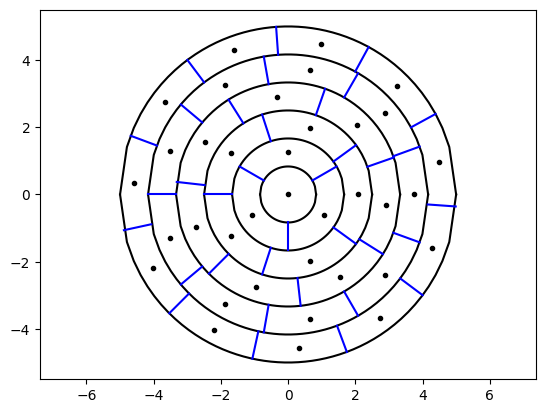

In [7]:
# Plotting the distribution of offset sources and the region represented by each

# Step 1: Use jitter.Determine_offsets_and_areas to calculate the set of offset source locations 
#         and sets of coordinates that define the boundaries of the regions represented by each source
x_offsets, y_offsets, A_offsets, x_outer_dict, yu_outer_dict, yl_outer_dict, boundary_coords_dict = \
jitter.Determine_offsets_and_areas(stellar_diam_and_jitter_keywords['outer_radius_of_offset_circle'],\
                                   stellar_diam_and_jitter_keywords['N_rings_of_offsets'], \
                                   stellar_diam_and_jitter_keywords['N_offsets_per_ring'],\
                                   stellar_diam_and_jitter_keywords['starting_offset_ang_by_ring'],\
                                   stellar_diam_and_jitter_keywords['r_ring0'],\
                                   stellar_diam_and_jitter_keywords['dr_rings'])

# Step 2: Use jitter.Plot_ALL_Offsets_And_Region_Outlines to draw the figure
jitter.Plot_ALL_Offsets_And_Region_Outlines(x_offsets,y_offsets,x_outer_dict,\
                                            yu_outer_dict,yl_outer_dict,\
                                            boundary_coords_dict,\
                                            stellar_diam_and_jitter_keywords['N_rings_of_offsets'],\
                                            stellar_diam_and_jitter_keywords['N_offsets_per_ring'])

The stellar diameter and jitter dictionary is used to set up the optics. It must be included in this step, or **corgisim** will default to representing the host star as a point source.

In [8]:
optics = instrument.CorgiOptics(cgi_mode, bandpass_corgisim, optics_keywords=optics_keywords,\
                                stellar_diam_and_jitter_keywords=stellar_diam_and_jitter_keywords, if_quiet=True)

CorgiOptics initialized with proper keywords.


From this point on, the steps are the same as in the other tutorials.

## Step 3: Simulate the image on the detector

In [9]:
# emccd keywords
gain = 1000
emccd_keywords = {'em_gain':gain}

# Set up the detector
detector = instrument.CorgiDetector(emccd_keywords)

# Define the exposure time
exp_time = 2000

# Test a single frame (Note that this step takes a bit of time because corgisim propagates each offset source in addition to the on-axis source.)
n_frames = 1
simulatedImage_list = observation.generate_observation_sequence(base_scene,optics,detector,exp_time,n_frames)

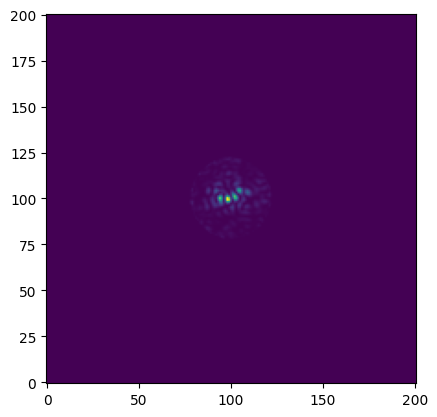

In [10]:
# Plot the host star image
host_star_image = simulatedImage_list[0].host_star_image.data
plt.imshow(host_star_image,origin='lower')